In [17]:
import gymnasium as gym
import numpy as np
from collections import namedtuple, deque

import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

import random


In [18]:
class DQNAgent:

    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory_size =100_000
        self.discount = 0.95    # 折扣率
        self.epsilon = 1.0  # 探索率
        self.learning_rate = 0.001
        self.update_interval = 4
        self.optimizer = Adam(learning_rate = self.learning_rate)
        self.q_network= self._build_network()
        self.target_q_network = self._build_network()
        
    
    def _build_network(self):

        model = Sequential()
        model.add(Input(shape=(self.state_size,)))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        return model

    def compute_loss(self, experiences):
        states, actions, rewards, next_states, done_flags = experiences
        max_q_next = tf.reduce_max(self.target_q_network(next_states), axis=-1)
        y_targets = rewards + (self.discount * max_q_next * (1-done_flags))
        q_values = self.q_network(states)
        q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]), tf.cast(actions, tf.int32)], axis=1))
        loss = MSE(y_targets, q_values)
        return loss

    def update_target_network(self):
        TAU=1e-3
        for target_weights, q_network_weights in zip(self.target_q_network.weights, self.q_network.weights):
            target_weights.assign(TAU * q_network_weights + (1.0-TAU) * target_weights)

    @tf.function
    def agent_learn(self, experiences):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(experiences)
        gradients = tape.gradient(loss, self.q_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.q_network.trainable_variables))
        self.update_target_network()

    def select_action(self,state):
        if random.random()<=self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.q_network(state).numpy()[0])
            


#     def get_experiences(self, memory_buffer):
#         experiences = random.sample(memory_buffer, k=64)
#         states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]),dtype=tf.float32)
#         actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.float32)
#         rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
#         next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
#         done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
#                                         dtype=tf.float32)
#         return (states, actions, rewards, next_states, done_vals)
    
    def fetch_sampled_experiences(self, experience_buffer):
        sampled_experiences = random.sample(experience_buffer, k=64)
        state_list = [exp.state for exp in sampled_experiences if exp is not None]
        action_list = [exp.action for exp in sampled_experiences if exp is not None]
        reward_list = [exp.reward for exp in sampled_experiences if exp is not None]
        next_state_list = [exp.next_state for exp in sampled_experiences if exp is not None]
        done_list = [exp.done for exp in sampled_experiences if exp is not None]

        states_tensor = tf.convert_to_tensor(state_list, dtype=tf.float32)
        actions_tensor = tf.convert_to_tensor(action_list, dtype=tf.float32)
        rewards_tensor = tf.convert_to_tensor(reward_list, dtype=tf.float32)
        next_states_tensor = tf.convert_to_tensor(next_state_list, dtype=tf.float32)
        done_tensor = tf.convert_to_tensor(np.array(done_list).astype(np.uint8), dtype=tf.float32)

        return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor

    def get_one_hot_encoding(self, state):
        state_vector = np.zeros(self.state_size)
        state_vector[state] = 1
        
        return state_vector

In [19]:
def Train_Agent(Agent, episodes, rewards, state_size):
    memory_buffer = deque(maxlen=Agent.memory_size)
    Agent.target_q_network.set_weights(Agent.q_network.get_weights())
    min_epsilon=0.01
    e_decay=0.05
    points_history = []
    time_step = 1000
    experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
     
    for i in range(episodes):
        observation = env.reset()
        state = observation[0]
        state = Agent.get_one_hot_encoding(state)
        total_rewards = 0
        timesup = False
        step = 0
          
        while not timesup:
            state_qn = np.reshape(state, [1, state_size])
            action=Agent.select_action(state_qn)
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            next_state = Agent.get_one_hot_encoding(next_state)
            memory_buffer.append(experience(state, action, reward, next_state, terminated))
            if (step+1) % Agent.update_interval == 0 and len(memory_buffer) > 64:
                experiences = Agent.fetch_sampled_experiences(memory_buffer)
                Agent.agent_learn(experiences)
            
            state = next_state
            total_rewards += reward
            step += 1
            
            if step == time_step:
                timesup = True

            if terminated:
                break

        points_history.append(total_rewards)
        avg_points = np.mean(points_history[-100:])

        #Update epsilon
        Agent.epsilon = max(min_epsilon,e_decay*Agent.epsilon)

        print(f"\rEpisode {i+1} | Total point average of the last {100} episodes: {avg_points:.2f}", end="")


        if(avg_points >= 8):
            print(f"Environment solved in {i+1} episodes!")
            break
            
        if (i+1) % 100 == 0:
            print(f"\rEpisode {i+1} | Total point average of the last {100} episodes: {avg_points:.2f}")
        rewards.append(total_rewards)
        
    env.close()
    print(f"\rTraining completed over {episodes} episodes")
    


Training completed over 10 episodes the last 100 episodes: -1324.00


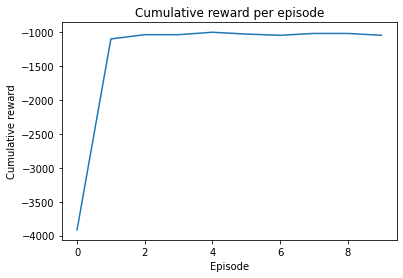

In [20]:
tf.random.set_seed(0)
env = gym.make('Taxi-v3')
env.reset()
rewards = []
episodes=10
state_size = env.observation_space.n
action_size = env.action_space.n
Agent=DQNAgent(state_size, action_size)
Train_Agent(Agent, episodes, rewards, state_size)
plt.title("Cumulative reward per episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.plot(rewards)
plt.show()
env.close()